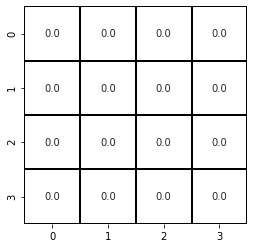

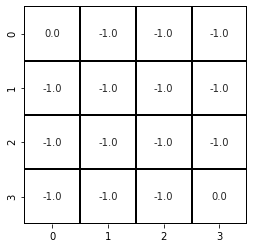

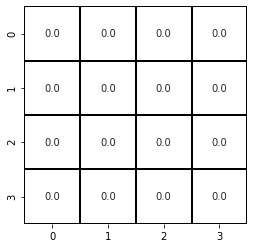

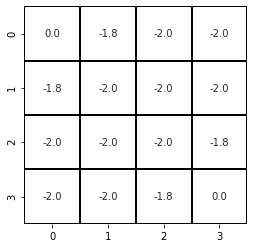

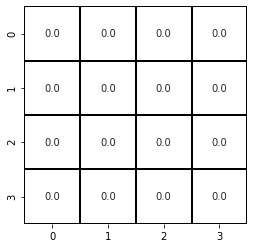

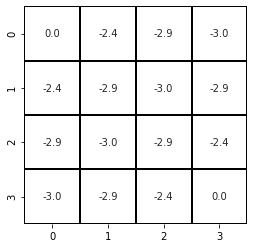

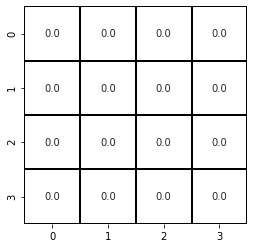

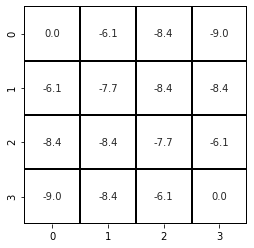

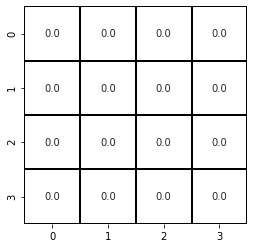

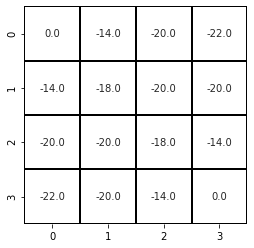

In [1]:
# MIT License

# Copyright (c) 2020 Eduardo Pignatelli

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap

W = LinearSegmentedColormap.from_list('w', ["w", "w"], N=256)

ACTIONS = {
    0: [1, 0],   # north
    1: [-1, 0],  # south
    2: [0, -1],  # west
    3: [0, 1],   # east
}


class GridWorld:
    def __init__(self, size=4):
        """
        A gridworld environment with absorbing states at [0, 0] and [size - 1, size - 1].
        Args:
            size (int): the dimension of the grid in each direction
            cell_reward (float): the reward return after extiting any non absorbing state
        """
        self.state_value = np.zeros((size, size))
        return

    def reset(self):
        self.state_value = np.zeros((size, size))
        return

    def step(self, state, action):
        # is terminal state?
        size = len(self.state_value) - 1
        if (state == (0, 0)) or (state == (size, size)):
            return state, 0

        s_1 = (state[0] + action[0], state[1] + action[1])
        reward = -1
        # out of bounds north-south
        if s_1[0] < 0 or s_1[0] >= len(self.state_value):
            s_1 = state
        # out of bounds east-west
        elif s_1[1] < 0 or s_1[1] >= len(self.state_value):
            s_1 = state

        return s_1, reward

    def render(self, title=None):
        """
        Displays the current value table of mini gridworld environment
        """
        size = len(self.state_value) if len(self.state_value) < 20 else 20
        fig, ax = plt.subplots(figsize=(size, size))
        if title is not None:
            ax.set_title(title)
        ax.grid(which='major', axis='both',
                linestyle='-', color='k', linewidth=2)
        sn.heatmap(self.state_value, annot=True, fmt=".1f", cmap=W,
                   linewidths=1, linecolor="black", cbar=False)
        plt.show()
        return fig, ax

    def bellman_expectation(self, state, probs, discount):
        """
        Makes a one step lookahead and applies the bellman expectation equation to the state self.state_value[state]
        Args:
            state (Tuple[int, int]): the x, y indices that define the address on the value table
            probs (List[float]): transition probabilities for each action
            in_place (bool): if False, the value table is updated after all the new values have been calculated.
                             if True the state [i, j] will new already new values for the states [< i, < j]
        Returns:
            (numpy.ndarrray): the new value for the specified state
        """
        # absorbing state
        value = 0
        for c, action in ACTIONS.items():
            s_1, reward = self.step(state, action)
            value += probs[c] * (reward + discount * self.state_value[s_1])
        return value


def policy_evaluation(env, policy=None, steps=1, discount=1., in_place=False):
    """
    Args:
        policy (numpy.array): a numpy 3-D numpy array, where the first two dimensions identify a state and the third dimension identifies the actions.
                              The array stores the probability of taking each action.
        steps (int): the number of iterations of the algorithm
        discount (float): discount factor for the bellman equations
        in_place (bool): if False, the value table is updated after all the new values have been calculated.
             if True the state [i, j] will new already new values for the states [< i, < j]
    """
    if policy is None:
        # uniform random policy
        policy = np.ones((*env.state_value.shape, len(ACTIONS))) * 0.25

    for k in range(steps):
        # cache old values if not in place
        values = env.state_value if in_place else np.empty_like(
            env.state_value)
        for i in range(len(env.state_value)):
            for j in range(len(env.state_value[i])):
                # apply bellman expectation equation to each state
                state = (i, j)
                value = env.bellman_expectation(state, policy[i, j], discount)
                values[i, j] = value * discount
        # set the new value table
        env.state_value = values
    return env.state_value


if __name__ == "__main__":
    # reprocuce Figure 4.1
    for k in [1, 2, 3, 10, 1000]:
        env = GridWorld(4)
        env.render()
        value_table = policy_evaluation(env, steps=k, in_place=False)
        env.render()
